# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

***Описание данных:***

Данные геологоразведки трёх регионов находятся в файлах:

`/datasets/geo_data_0.csv`

`/datasets/geo_data_1.csv`

`/datasets/geo_data_2.csv`

* `id` — уникальный идентификатор скважины;
* `f0, f1, f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
* `product` — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
from numpy.random import RandomState

import matplotlib.pyplot as plt
import seaborn as sns
sns.set();

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [3]:
RANDOM_SEED = 0

In [4]:
df_0 = pd.read_csv('../datasets/geo_data_0_7ds.csv')
df_1 = pd.read_csv('../datasets/geo_data_1_7ds.csv')
df_2 = pd.read_csv('../datasets/geo_data_2_7ds.csv')

In [5]:
show_sample = lambda x: display(x.sample(5, random_state=RANDOM_SEED).reset_index(drop=True))

In [6]:
show_sample(df_0)
show_sample(df_1)
show_sample(df_2)

,id,f0,f1,f2,product
0,zMatX,0.881376,0.273600,2.770651,49.723143
1,muBEx,-0.991020,0.010620,3.233630,10.583795
2,DMAPr,-0.987623,0.017871,5.005426,139.110613
3,fasrx,2.081966,0.426730,2.638579,85.109875
4,0XaIy,0.850498,0.473509,3.575604,39.726827


,id,f0,f1,f2,product
0,gnvG6,13.682535,-1.577749,4.999462,134.766305
1,KGfJ0,-4.834251,-0.349029,4.996602,137.945408
2,Km7yX,-7.287642,-4.184750,0.001329,3.179103
3,bGQtv,-10.041103,-16.919151,3.999895,110.992147
4,CuYNo,-8.650003,-4.526214,5.012777,137.945408


,id,f0,f1,f2,product
0,GdnWX,-0.838132,-0.968042,4.074363,129.102262
1,z2rQ2,0.370981,-0.573846,-3.568113,61.285744
2,vZROH,0.856767,1.441619,4.895820,65.026246
3,6AgeD,1.989628,-1.343347,3.242798,62.334048
4,nXQ8W,2.194257,-2.180922,1.699123,150.002134


In [7]:
print('Размер датасета df_0:', df_0.shape)
print('Размер датасета df_1:', df_1.shape)
print('Размер датасета df_2:', df_2.shape)

Размер датасета df_0: (100000, 5)
Размер датасета df_1: (100000, 5)
Размер датасета df_2: (100000, 5)


Размеры трех таблиц одинаковые. 

In [8]:
print(df_0.info(memory_usage=True))
print('----------------------------')
print(df_1.info(memory_usage=True))
print('----------------------------')
print(df_2.info(memory_usage=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries

Видим, что разрядность слишком высокая для хранения наших данных. Поэтому мы можем оптимизировать типы данных и ускорить работу кода.  Почти все поля типа `float`  за исключением `id`.

In [9]:
float_features = df_0.select_dtypes(include='float').columns

df_0[float_features] = df_0[float_features].apply(pd.to_numeric, downcast='float')
df_1[float_features] = df_1[float_features].apply(pd.to_numeric, downcast='float')
df_2[float_features] = df_2[float_features].apply(pd.to_numeric, downcast='float')

In [10]:
print(df_0.info(memory_usage=True))
print('----------------------------')
print(df_1.info(memory_usage=True))
print('----------------------------')
print(df_2.info(memory_usage=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float32
 2   f1       100000 non-null  float32
 3   f2       100000 non-null  float32
 4   product  100000 non-null  float32
dtypes: float32(4), object(1)
memory usage: 2.3+ MB
None
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float32
 2   f1       100000 non-null  float32
 3   f2       100000 non-null  float32
 4   product  100000 non-null  float32
dtypes: float32(4), object(1)
memory usage: 2.3+ MB
None
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries

Место немного сэкономили :) Пропусков в данных нет, это и так видно. Проверим наличие дубликатов.

In [11]:
print('Наличие дубликатов в df_0:', df_0.duplicated().sum())
print('Наличие дубликатов в df_1:', df_1.duplicated().sum())
print('Наличие дубликатов в df_2:', df_2.duplicated().sum())

Наличие дубликатов в df_0: 0
Наличие дубликатов в df_1: 0
Наличие дубликатов в df_2: 0


Дубликатов нет.

Посмотрим распределения фичей и таргета для всех регионов.

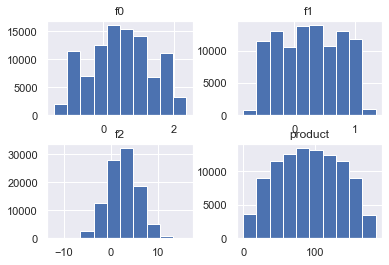

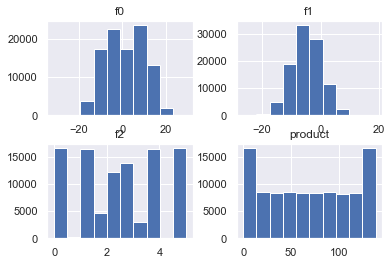

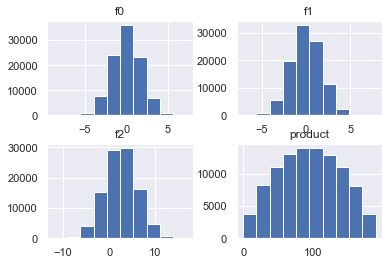

In [12]:
df_range = [df_0, df_1, df_2]
for df in df_range:
    df[float_features].hist();
    plt.show()


Почти по всем распределениям из датасета `df_1` видим, что они отличаются от нормального, у `f0`, `f2` и `product` видим несколько пиков. В то время как распределение фичей и таргета в датасетах `df_0` и `df_2`  симметричны.

Построим корреляционные матрицы для всех регионов.

In [13]:
corr_matrix_df_0 = df_0.corr()
corr_matrix_df_1 = df_1.corr()
corr_matrix_df_2 = df_2.corr()

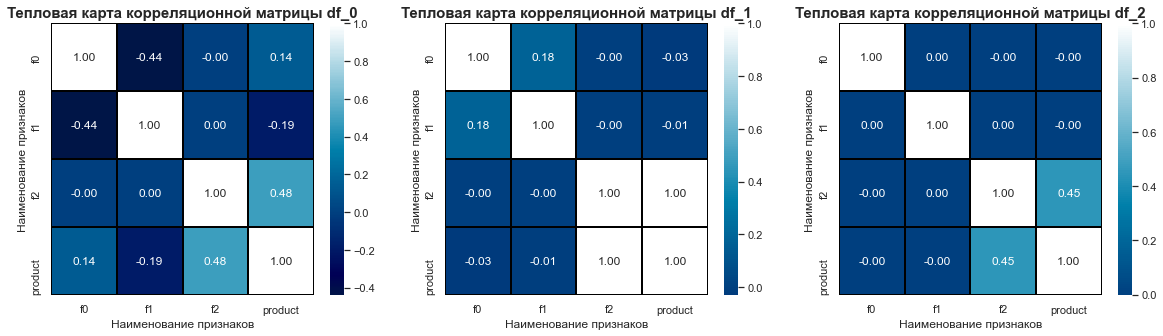

In [14]:
plt.subplots(figsize = (20, 5))

plt.subplot(1, 3, 1)
plt.title('Тепловая карта корреляционной матрицы df_0', size=15, fontweight="bold")
sns.heatmap(corr_matrix_df_0, annot=True, fmt='.2f', 
                      linewidth=1, linecolor='black', vmax=1, center=0, cmap='ocean')
plt.xlabel('Наименование признаков')
plt.ylabel('Наименование признаков')

plt.subplot(1, 3, 2)
plt.title('Тепловая карта корреляционной матрицы df_1', size=15, fontweight="bold")
sns.heatmap(corr_matrix_df_1, annot=True, fmt='.2f', 
                      linewidth=1, linecolor='black', vmax=1, center=0, cmap='ocean')
plt.xlabel('Наименование признаков')
plt.ylabel('Наименование признаков')

plt.subplot(1, 3, 3)
plt.title('Тепловая карта корреляционной матрицы df_2', size=15, fontweight="bold")
sns.heatmap(corr_matrix_df_2, annot=True, fmt='.2f', 
                      linewidth=1, linecolor='black', vmax=1, center=0, cmap='ocean')
plt.xlabel('Наименование признаков')
plt.ylabel('Наименование признаков')

plt.show()

In [15]:
#https://www.askpython.com/python/examples/heatmaps-in-python
#https://nickmccullum.com/python-visualization/subplots/
#https://stackoverflow.com/questions/19614400/add-title-to-collection-of-pandas-hist-plots

По первому региону видим сильную корреляцию признака `f2` с целевой переменной `product`, в остальных случаях корреляция находится в пределах разумного.

### Выводы

* Размеры всех трех датасетов одинаковые - 100000 строк и 5 столбцов.
* У них одинаковые поля
* Пропусков нет
* Дубликатов нет
* Оптимизировали типы данных для экономии памяти
* Почти по всем распределениям из датасета `df_1` видим, что они отличаются от нормального, у `f0`, `f2` и `product` видим несколько пиков. В то время как распределение фичей и таргета в датасетах `df_0` и `df_2`  симметричны.
* По первому региону выидим сильную корреляцию признака `f2` с целевой переменной `product`, в остальных случаях корреляция находится в пределах разумного.

## Обучение и проверка модели для каждого региона

### Обучение и проверка модели (c разбивкой данных на обучающую и валидационную выборки в соотношении 75:25)

In [16]:
def split_train_pred(data):
    '''
    split_train_pred - функция  разбивает выборки на обучающую и валидационную, масштабирует признаки, 
    строит модель линейной регрессии
    Input: data - таблица с данными
    Output: predictions, rmse, r2
    '''
    features = data.drop(['product', 'id'], axis=1)
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, 
                                                                                  test_size=0.25, 
                                                                                  random_state=RANDOM_SEED)
    
    scaler = StandardScaler()
    features_train = scaler.fit_transform(features_train)
    features_valid = scaler.fit_transform(features_valid)

    model = LinearRegression(normalize=False)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    predictions = pd.Series(predictions)
    
    rmse = (mean_squared_error(predictions, target_valid))**(0.5)
    average_prod = sum(predictions) / len(predictions)
    r2 = r2_score(target_valid, predictions)
    
    print("RMSE: {:.2f}".format(rmse))
    print("Средний запас предсказанного сырья: {:.2f}".format(average_prod))
    print("Коэффициент детерминации: {:.2f}".format(r2))
    
    return (predictions, target_valid.reset_index(drop=True), rmse, r2)

In [17]:
# Based on: https://stackoverflow.com/a/17303428 (для красивого оформления результата z-теста)
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [18]:
d = {}
for region in df_range:
    name = [x for x in globals() if globals()[x] is region][0]
    print(color.UNDERLINE + "Регион " + name + color.END)
    #сохраняем предсказания, реальные значения RMSE и R2
    d["predictions" + str(name)], d["target_valid" + str(name)], d["rmse" + str(name)], d["r2" + str(name)] = split_train_pred(region)
    print("__________________________________________\n\n")

Регион df_0
RMSE: 37.48
Средний запас предсказанного сырья: 92.51
Коэффициент детерминации: 0.28
__________________________________________


Регион df_1
RMSE: 0.99
Средний запас предсказанного сырья: 68.72
Коэффициент детерминации: 1.00
__________________________________________


Регион df_2
RMSE: 40.31
Средний запас предсказанного сырья: 94.84
Коэффициент детерминации: 0.19
__________________________________________




### Выводы

Судя по среднему запасу предсказанного сырья можно сказать, что наиболее прибыльный регион - df_1. **RMSE** - это среднеквадратичная ошибка (измеряет среднеквадратичную ошибку наших прогнозов). Чем выше это значение, тем хуже модель. Среди всех регионов RMSE хуже всех у региона  df_2. Коэффициент детерминации у региона 0 и региона 2 слишком низкий, что свидетельствует о слабой предсказательной силе нашей модели. Высокий коэффициент детерминации у df_1 региона может объясняться тем, что признак `f2` сильно коррелирует с целевой переменной `product`.

## Подготовка к расчёту прибыли

**Вводные для расчета прибыли**

- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

- Бюджет на разработку скважин в регионе — 10 млрд рублей.

- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [19]:
BUDGET = 10_000_000_000
RESEARCH_POINTS = 500
BEST_POINTS = 200
INCOME_PER_BARREL = 450
INCOME_PER_PRODUCT = 450_000
BARREL_IN_UNIT = 1000

#### Расчет достаточного объёма сырья для безубыточной разработки новой скважины.

In [20]:
MIN_VOLUME = BUDGET/BEST_POINTS/INCOME_PER_PRODUCT
print(f'Достаточный объём сырья для безубыточной разработки новой скважины: {MIN_VOLUME:.2f}')



Достаточный объём сырья для безубыточной разработки новой скважины: 111.11


 ####  Сравнение полученного объём сырья со средним запасом в каждом регионе. 

In [21]:
for i in df_range:
    name = [x for x in globals() if globals()[x] is i][0]
    print(f"Средний запас в регионе {name} составляет: {i['product'].mean():.2f}")

Средний запас в регионе df_0 составляет: 92.50
Средний запас в регионе df_1 составляет: 68.82
Средний запас в регионе df_2 составляет: 95.00


Средний запас в каждом регионе ниже, чем достаточный объем сырья для безубыточной разработки новой скважины. Максимальный средний объем составляет 95 в регионе `df_2`.

### Выводы

- Достаточный объём сырья для безубыточной разработки новой скважины: 111.11

- Средний запас в каждом регионе ниже, чем достаточный объем сырья для безубыточной разработки новой скважины. Максимальный средний объем составляет 95 в регионе `df_2`.

## Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели

Напишем функцию для расчета прибыли по выбранным скважинам. Логика данной функции следующая:

- Выберем скважины с максимальными значениями предсказаний

- Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям

- Рассчитаем прибыль для полученного объёма сырья.

In [22]:
def profit(predictions, target):
    product_top_predicted = predictions.sort_values(ascending=False)
    product_top_target = target[product_top_predicted.index][:BEST_POINTS]
    return (round((product_top_target.sum()*INCOME_PER_PRODUCT)-BUDGET, 2))

## Расчет рисков и прибыли для каждого региона

- Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков (Убыток — это отрицательная прибыль)


Регион df_0
Средняя прибыль = 473114930.73
95%-ый доверительный интервал: (-69756440.42724998, 1003474663.0834999)
Риск убытков = 4.45%


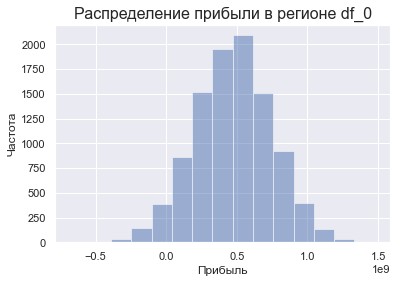

----------------------------------------------------------------------------
Регион df_1
Средняя прибыль = 530353139.17
95%-ый доверительный интервал: (116706025.39550003, 957826271.9749998)
Риск убытков = 0.52%


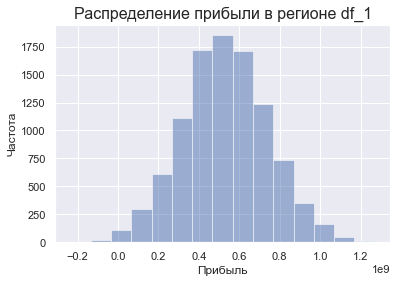

----------------------------------------------------------------------------
Регион df_2
Средняя прибыль = 425031298.17
95%-ый доверительный интервал: (-121795754.39324999, 978227641.6002499)
Риск убытков = 6.18%


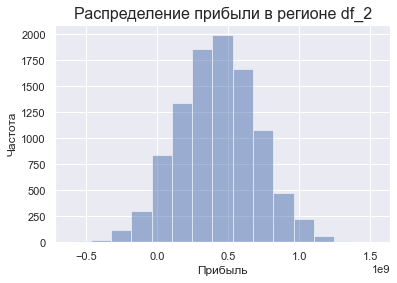

----------------------------------------------------------------------------


In [35]:
state = RandomState(1234)

for i in df_range:
    name = [x for x in globals() if globals()[x] is i][0]
    
    target = d["target_valid" + str(name)]
    predictions = d["predictions" + str(name)]
    
    profit_values = []
    for j in range(10000):
        target_sample = target.sample(n=RESEARCH_POINTS, replace=True, random_state=state) #Allow or disallow sampling of the same row more than once.
        predictions_sample = predictions[target_sample.index]
        profit_values.append(profit(predictions_sample, target_sample))
    profit_values = pd.Series(profit_values)
        
    mean_profit = profit_values.mean()
    confidence_interval = (profit_values.quantile(0.025), profit_values.quantile(0.975))
    negative_profit_chance = (profit_values < 0).mean()
    
    print(color.UNDERLINE + "Регион " + name + color.END)
    print(f"Средняя прибыль = {mean_profit:.2f}")
    print(f"95%-ый доверительный интервал: {confidence_interval}")
    print(f"Риск убытков = {negative_profit_chance:.2%}")

    plt.title('Распределение прибыли в регионе '+ str(name), fontsize=16)
    plt.hist(profit_values, alpha=0.5, bins=15)
    plt.xlabel('Прибыль')
    plt.ylabel('Частота')
    plt.show()
    
    print('----------------------------------------------------------------------------')

### Выводы

В части рисков нам подходит только регион `df_1`, т.к. это единственный регион, который удовлетворяет условию вероятности убытков меньше 2.5%, здесь риск убытков составляет 0.52%. Также этот регион характеризуется наибольшей средней прибылью (она составляет 530 353 139 руб.)

Однако данные по региону `df_1` выглядят не вполне исследованными, а именно:

- Вызывает подозрение корреляция признака `f2` с целевой переменной `product`, а также коэффициент детерминации, близкий к 1 - мы получили идеальную модель для предсказаний

Для проведения исследования с разных сторон может оказаться полезным:

- Использование менее консервативных моделей - например, градиентного бустинга

- Пересмотр критериев риска, тогда можно присмотреться к региону `df_0 `

## Финальные выводы

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: модели обучены и проверены
    - [ ]  Данные корректно разбиты на обучающую и валидационную выборки
    - [ ]  Модели обучены, предсказания сделаны
    - [ ]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [ ]  На экране напечатаны результаты
    - [ ]  Сделаны выводы
- [ ]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [ ]  Для всех ключевых значений созданы константы Python
    - [ ]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [ ]  По предыдущему пункту сделаны выводы
    - [ ]  Написана функция расчёта прибыли
- [ ]  Выполнен шаг 4: посчитаны риски и прибыль
    - [ ]  Проведена процедура *Bootstrap*
    - [ ]  Все параметры бутстрепа соответствуют условию
    - [ ]  Найдены все нужные величины
    - [ ]  Предложен регион для разработки месторождения
    - [ ]  Выбор региона обоснован